neural_network

# ARIMA

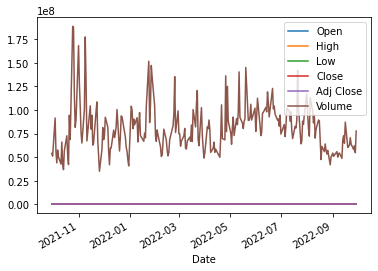

In [14]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

from pandas.plotting import autocorrelation_plot

def parser(x):
	return datetime.strptime(x,'%Y-%m-%d')
 
series = read_csv('data/stock_yfinance_data_tsla.csv', header=0, parse_dates=[0], index_col=0)
series = series.drop('Stock Name', axis=1)
series.plot()
pyplot.show()

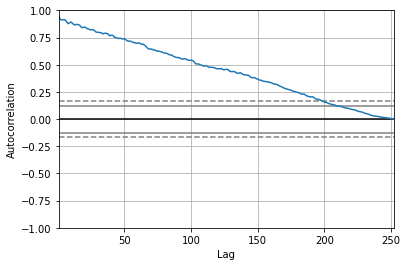

In [15]:
autocorrelation_plot(series)
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  252
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -986.629
Date:                Fri, 08 Nov 2024   AIC                           1985.259
Time:                        20:08:57   BIC                           2006.412
Sample:                    09-30-2021   HQIC                          1993.771
                         - 09-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0189      0.073     -0.260      0.795      -0.161       0.123
ar.L2          0.0037      0.059      0.063      0.949      -0.112       0.119
ar.L3         -0.0277      0.080     -0.347      0.7

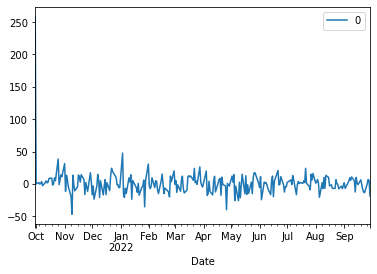

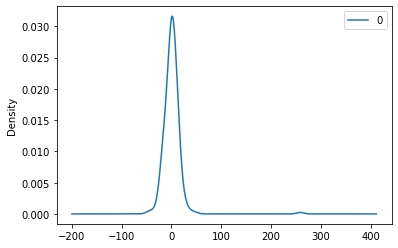

                0
count  252.000000
mean     1.064161
std     20.421631
min    -46.962810
25%     -6.788812
50%      0.796174
75%      6.653102
max    258.493347


In [20]:

# fit an ARIMA model and plot residual errors
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

series = series['Close']  # Or replace 'Close' with any other single column you want to analyze

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

predicted=227.794442, expected=253.210007
predicted=258.229873, expected=252.753326
predicted=248.772017, expected=246.789993
predicted=253.605189, expected=258.333344
predicted=253.201663, expected=234.516663
predicted=241.306323, expected=238.279999
predicted=234.274057, expected=238.886673
predicted=243.679990, expected=241.866669
predicted=237.952353, expected=239.706665
predicted=236.920710, expected=232.229996
predicted=235.718248, expected=215.736664
predicted=209.181455, expected=220.889999
predicted=227.928750, expected=233.000000
predicted=230.013901, expected=213.100006
predicted=213.118974, expected=216.759995
predicted=216.421294, expected=237.036667
predicted=239.401328, expected=236.086670
predicted=229.421829, expected=235.070007
predicted=240.196775, expected=245.706665
predicted=248.917132, expected=244.919998
predicted=240.646234, expected=232.663330
predicted=234.715102, expected=228.490005
predicted=229.365481, expected=224.473328
predicted=223.009706, expected=227

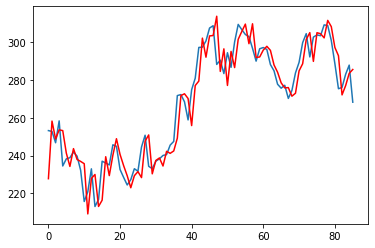

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(15,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# LSTM

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [16]:
data = pd.read_csv('data/stock_yfinance_data_tsla.csv', header=0, index_col=0, parse_dates=True)
data = data[['Open', 'High', 'Low', 'Close']]

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

In [22]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Extract sequence of length `seq_length`
        X_sequence = data.iloc[i:i+seq_length].values.tolist()
        X.append(X_sequence)
        
        # Target is the 'Close' price after the sequence
        y.append(data.iloc[i + seq_length]['Close'])
    return X, y

In [23]:
# Hyperparameters
seq_length = 60  # The number of time steps (days) to look back
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data.index[:len(y_train_actual)], y_train_actual, label='Train Actual')
plt.plot(data.index[len(y_train_actual):len(y_train_actual) + len(y_test_actual)], y_test_actual, label='Test Actual')
plt.plot(data.index[:len(train_predict)], train_predict, label='Train Predict')
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict, label='Test Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()